In [2]:

import logging
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.fft as fft
from torch.nn.parameter import Parameter
# import matplotlib.pyplot as plt
import scipy.io as sio
# import h5py

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import re


In [3]:
class TimeDataSetLinearResiduals(torch.utils.data.Dataset):
    def __init__(self, X, t_grid, x_grid):
        super(TimeDataSetLinearResiduals, self).__init__()
        assert X.shape[1] == t_grid.shape[-1]
        self.X = torch.tensor(X, dtype=torch.cfloat)
        self.t = torch.tensor(t_grid.flatten(), dtype=torch.float)
        self.x_grid = torch.tensor(x_grid, dtype=torch.float).view(-1, 1)
        self.n_tsteps = self.t.shape[0] - 1
        self.n_batches = self.X.shape[0]
        self.dataset_len = self.n_tsteps * self.n_batches
        n_gridpoints = self.X.shape[-1]
        self.wave_numbers = torch.square(torch.mul(torch.arange(-n_gridpoints/2, n_gridpoints/2), 1/n_gridpoints))
        

    def linear_part(self, x_0, t):
        # x_0 has shape (self.X.shape[-1],)
        # t is a float
        x_0_hat = torch.fft.fft(x_0)
        # exp(-i /2 * t * |xi|^2 )
        exp_term = torch.exp(torch.mul(self.wave_numbers, - 1j * t / 2 * 2 ))
        out = torch.fft.ifft(torch.mul(exp_term, x_0_hat))
        return out
        
    def make_x_train(self, X, single_batch=False):
        # X has shape (nbatch, 1, grid_size)
        n_batches = X.shape[0] if len(X.shape) > 1 else 1

        # Convert to tensor
        X_input = torch.view_as_real(torch.tensor(X, dtype=torch.cfloat))


        if single_batch:
            X_input = torch.cat((X_input, self.x_grid), dim=1)
        else:
            x_grid_i = self.x_grid.repeat(n_batches, 1, 1)
            X_input = torch.cat((X_input.view((n_batches, -1, 2)), x_grid_i), axis=2)

        return X_input

    def __getitem__(self, idx):
        idx_original = idx
        t_idx = int(idx % self.n_tsteps) + 1
        idx = int(idx // self.n_tsteps)
        batch_idx = int(idx % self.n_batches)
        x = self.make_x_train(self.X[batch_idx, 0], single_batch=True) #.reshape(self.output_shape)
        y = self.X[batch_idx, t_idx] #.reshape(self.output_shape)
        t = self.t[t_idx]
        lin_part = self.linear_part(self.X[batch_idx, 0], t)
        return x,y,t,lin_part

    def __len__(self):
        return self.dataset_len

    def __repr__(self):
        return "TimeDataSetLinearResiduals with length {}, n_tsteps {}, n_batches {}".format(self.dataset_len,
                                                                                            self.n_tsteps,
                                                                                            self.n_batches)

In [4]:
DATA_FP = '/home/owen/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'

In [5]:
d = sio.loadmat(DATA_FP)
X = d['output']
t = d['t']
x_grid = d['x']

In [6]:
tt = TimeDataSetLinearResiduals(X, t, x_grid)

In [21]:
x_0_flat = torch.ones(1024)

In [26]:
def build_lin_soln(x_0, t_dset):
    out = np.zeros((100, 1024), dtype=np.cfloat)
    for i in range(100):
        t = i/100 * 2 * np.pi
        out[i] = t_dset.linear_part(x_0, t)
    return out

In [27]:
zz = build_lin_soln(x_0_flat, tt)

In [17]:
import matplotlib.pyplot as plt

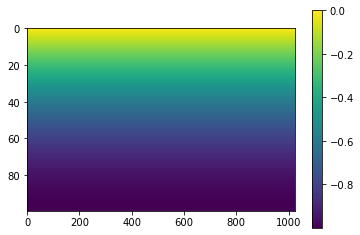

In [30]:
plt.imshow(np.imag(zz), aspect=7)
plt.colorbar()
plt.show()